## 1. Setup & Check GPU

In [1]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU! Go to Runtime → Change runtime type → GPU")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
!pip install -q segmentation-models-pytorch albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00


## 2. Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Configuration

In [4]:
# ============ CONFIG ============
import os

# Dataset paths - MASKS ARE ALREADY CREATED IN segmentation2 folder
DATASET_ROOT = "/content/drive/MyDrive/segmentation2"

# Training settings
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
EPOCHS = 40
IMG_SIZE = 640
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
PATIENCE = 20

# Class names
CLASS_NAMES = [
    'background',
    'Longitudinal_crack',
    'Transverse_crack',
    'Alligator_crack',
    'Pothole',
    'Other_damage'
]
NUM_CLASSES = len(CLASS_NAMES)

# Output directory
OUTPUT_DIR = "/content/unet_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Model: U-Net with {ENCODER} encoder")
print(f"Epochs: {EPOCHS}, Batch: {BATCH_SIZE}, ImgSize: {IMG_SIZE}")
print(f"Classes: {NUM_CLASSES} - {CLASS_NAMES}")

Model: U-Net with resnet34 encoder
Epochs: 40, Batch: 8, ImgSize: 640
Classes: 6 - ['background', 'Longitudinal_crack', 'Transverse_crack', 'Alligator_crack', 'Pothole', 'Other_damage']


## 4. Verify Dataset Structure

In [5]:
print("📂 Checking dataset structure...\n")

for split in ['train', 'val', 'test']:
    images_dir = os.path.join(DATASET_ROOT, split, 'images')
    masks_dir = os.path.join(DATASET_ROOT, split, 'masks')

    if os.path.exists(images_dir) and os.path.exists(masks_dir):
        n_images = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        n_masks = len([f for f in os.listdir(masks_dir) if f.endswith('.png')])
        print(f"{split.upper()}:")
        print(f"  Images: {n_images}")
        print(f"  Masks:  {n_masks}")
        print()
    else:
        print(f"⚠️ {split.upper()}: NOT FOUND")
        print()

print("✓ Dataset verification complete!")

📂 Checking dataset structure...

TRAIN:
  Images: 2286
  Masks:  2286

VAL:
  Images: 447
  Masks:  447

TEST:
  Images: 439
  Masks:  439

✓ Dataset verification complete!


## 5. Create Dataset and DataLoader

In [6]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RoadDamageDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

# Transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets and loaders
train_dataset = RoadDamageDataset(
    os.path.join(DATASET_ROOT, 'train', 'images'),
    os.path.join(DATASET_ROOT, 'train', 'masks'),
    transform=train_transform
)

val_dataset = RoadDamageDataset(
    os.path.join(DATASET_ROOT, 'val', 'images'),
    os.path.join(DATASET_ROOT, 'val', 'masks'),
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Train: {len(train_dataset)} | Val: {len(val_dataset)}")

✓ Train: 2286 | Val: 447


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 6. Proposed Hybrid Architecture

### Combining U-Net and YOLO for Enhanced Road Damage Segmentation

This proposed architecture aims to leverage the strengths of both U-Net and YOLO paradigms to create a more robust and efficient model for road damage segmentation.

**Inspiration from U-Net:**

The core of the segmentation task will still rely heavily on U-Net's fundamental principles:
*   **Encoder-Decoder Structure:** The model will maintain the classic encoder-decoder structure. The encoder progressively downsamples the input image, capturing high-level semantic information, while the decoder upsamples these features to reconstruct a segmentation mask.
*   **Skip Connections:** To preserve fine-grained details lost during downsampling, skip connections will be incorporated. These connections will transfer features from corresponding encoder layers directly to the decoder, enabling the decoder to produce more precise boundaries and detailed masks for various damage types.

**Incorporating YOLO Concepts:**

To enhance efficiency and multi-scale feature detection, elements inspired by YOLO's design will be integrated:
*   **Efficient Backbone Network:** Instead of a traditional U-Net encoder, the model will utilize a more efficient and lightweight backbone network, similar to those found in YOLO models (e.g., CSPDarknet, YOLOv5's custom backbones). This will allow for faster inference and potentially reduce computational overhead while maintaining strong feature extraction capabilities.
*   **Multi-Scale Feature Aggregation for Segmentation:** Drawing from YOLO's multi-scale detection heads, the decoder will be designed to fuse features from various scales of the encoder output more effectively. This could involve techniques like Feature Pyramid Networks (FPN) or Path Aggregation Network (PAN) which are commonly used in YOLO for better feature representation across different object sizes. By adapting these multi-scale aggregation strategies, the segmentation head will be better equipped to detect and segment road damages of varying sizes, from small cracks to large potholes.
*   **Direct Prediction (adapted):** While YOLO directly predicts bounding boxes and classes, the segmentation adaptation would involve a more direct, perhaps parallel, prediction of segmentation masks at different scales within the decoder, potentially leading to more streamlined and efficient mask generation.

**Motivation:**

The goal is to combine U-Net's proven ability for accurate pixel-level classification with YOLO's advancements in speed and multi-scale feature handling. This hybrid approach is expected to yield a segmentation model that is not only accurate in localizing and delineating road damages but also performs efficiently, making it suitable for real-time or resource-constrained applications.


## Implement Inspired Architecture

### Subtask:
Create a new code cell to implement the proposed architecture using PyTorch. This will involve defining custom `nn.Module` classes or intelligently combining existing building blocks from `segmentation_models_pytorch` or other common deep learning libraries to realize the conceptual design.


In [7]:
import torch
import segmentation_models_pytorch as smp

hybrid_model = smp.PAN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hybrid_model = hybrid_model.to(device)

print(f"✓ Hybrid Model (PAN with {ENCODER} encoder) built and moved to {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✓ Hybrid Model (PAN with resnet34 encoder) built and moved to cuda


## Instantiate and Prepare New Model for Training

### Subtask:
Instantiate the newly implemented model, move it to the appropriate device, and configure its optimizer and a learning rate scheduler with appropriate hyperparameters.


In [8]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

hybrid_optimizer = AdamW(hybrid_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
hybrid_scheduler = ReduceLROnPlateau(hybrid_optimizer, mode='max', factor=0.5, patience=PATIENCE)

print("✓ Hybrid model optimizer and scheduler ready")

✓ Hybrid model optimizer and scheduler ready


## Train the New Architecture

### Subtask:
Create a new training loop code cell, similar to the existing U-Net training loop, but adapted for the new model. This loop will iterate through epochs, performing forward and backward passes using the defined loss function and optimizer. It will also track training and validation metrics, saving the model's weights based on the best validation performance (e.g., mIoU).


In [9]:
from tqdm import tqdm
import time
import os
import torch.nn as nn
import torch
import numpy as np

# Definitions for DiceLoss, combined_loss, calculate_iou, and calculate_pixel_accuracy
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Ensure NUM_CLASSES is accessible from the global scope
        # If not, it would need to be passed or redefined, but given the notebook structure, it's global.
        pred = torch.softmax(pred, dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, NUM_CLASSES).permute(0, 3, 1, 2).float()
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

def combined_loss(pred, target):
    return ce_loss(pred, target) + dice_loss(pred, target)

def calculate_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        if union > 0:
            ious.append((intersection / union).item())
    return np.mean(ious) if ious else 0.0

def calculate_pixel_accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    correct = (pred == target).sum()
    total = target.numel()
    return (correct / total).item()

hybrid_history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_accuracy': [], 'lr': []}
best_hybrid_iou = 0.0
hybrid_patience_counter = 0
best_hybrid_model_path = os.path.join(OUTPUT_DIR, 'best_hybrid_model.pth')

print("🚀 Starting training for hybrid model...\n")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS} (Hybrid Model)")

    # Training
    hybrid_model.train()
    train_loss_epoch = 0.0
    for images, masks in tqdm(train_loader, desc='Hybrid Training'):
        images, masks = images.to(device), masks.to(device)
        hybrid_optimizer.zero_grad()
        outputs = hybrid_model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        hybrid_optimizer.step()
        train_loss_epoch += loss.item()
    train_loss_epoch /= len(train_loader)

    # Validation
    hybrid_model.eval()
    val_loss_epoch = val_iou_epoch = val_accuracy_epoch = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Hybrid Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = hybrid_model(images)
            val_loss_epoch += combined_loss(outputs, masks).item()
            val_iou_epoch += calculate_iou(outputs, masks, NUM_CLASSES)
            val_accuracy_epoch += calculate_pixel_accuracy(outputs, masks)

    val_loss_epoch /= len(val_loader)
    val_iou_epoch /= len(val_loader)
    val_accuracy_epoch /= len(val_loader)

    hybrid_history['train_loss'].append(train_loss_epoch)
    hybrid_history['val_loss'].append(val_loss_epoch)
    hybrid_history['val_iou'].append(val_iou_epoch)
    hybrid_history['val_accuracy'].append(val_accuracy_epoch)
    hybrid_history['lr'].append(hybrid_optimizer.param_groups[0]['lr'])

    print(f"Hybrid Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | mIoU: {val_iou_epoch:.4f} | Acc: {val_accuracy_epoch:.4f}")

    hybrid_scheduler.step(val_iou_epoch)

    if val_iou_epoch > best_hybrid_iou:
        best_hybrid_iou = val_iou_epoch
        hybrid_patience_counter = 0
        torch.save({'model': hybrid_model.state_dict(), 'iou': best_hybrid_iou, 'history': hybrid_history}, best_hybrid_model_path)
        print(f"✅ Best hybrid model saved! mIoU: {best_hybrid_iou:.4f}")
    else:
        hybrid_patience_counter += 1
        if hybrid_patience_counter >= PATIENCE:
            print("Early stopping for hybrid model!")
            break

print(f"\n🎉 Hybrid model training done in {(time.time()-start_time)/60:.1f} min | Best mIoU: {best_hybrid_iou:.4f}")

🚀 Starting training for hybrid model...


Epoch 1/40 (Hybrid Model)


Hybrid Training:   1%|          | 2/286 [00:13<32:40,  6.90s/it]


KeyboardInterrupt: 

In [13]:
import shutil
drive_hybrid_backup = "/content/drive/MyDrive/unet_models"
os.makedirs(drive_hybrid_backup, exist_ok=True)
shutil.copy(best_hybrid_model_path, os.path.join(drive_hybrid_backup, 'hybrid_best.pth'))
print("✓ Hybrid model backed up to Drive")

✓ Hybrid model backed up to Drive


## 7. Test Set Evaluation for Hybrid Model

In [14]:
checkpoint_hybrid = torch.load(best_hybrid_model_path, weights_only=False)
hybrid_model.load_state_dict(checkpoint_hybrid['model'])
hybrid_model.eval()

test_dataset = RoadDamageDataset(
    os.path.join(DATASET_ROOT, 'test', 'images'),
    os.path.join(DATASET_ROOT, 'test', 'masks'),
    transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_iou_hybrid = test_acc_hybrid = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc='Hybrid Testing'):
        images, masks = images.to(device), masks.to(device)
        outputs = hybrid_model(images)
        test_iou_hybrid += calculate_iou(outputs, masks, NUM_CLASSES)
        test_acc_hybrid += calculate_pixel_accuracy(outputs, masks)

test_iou_hybrid /= len(test_loader)
test_acc_hybrid /= len(test_loader)

print(f"\n📊 Hybrid Model Test Results: mIoU={test_iou_hybrid:.4f} | Accuracy={test_acc_hybrid:.4f}")

Hybrid Testing: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


📊 Hybrid Model Test Results: mIoU=0.4268 | Accuracy=0.9279


Visualizing 6 hybrid model predictions...


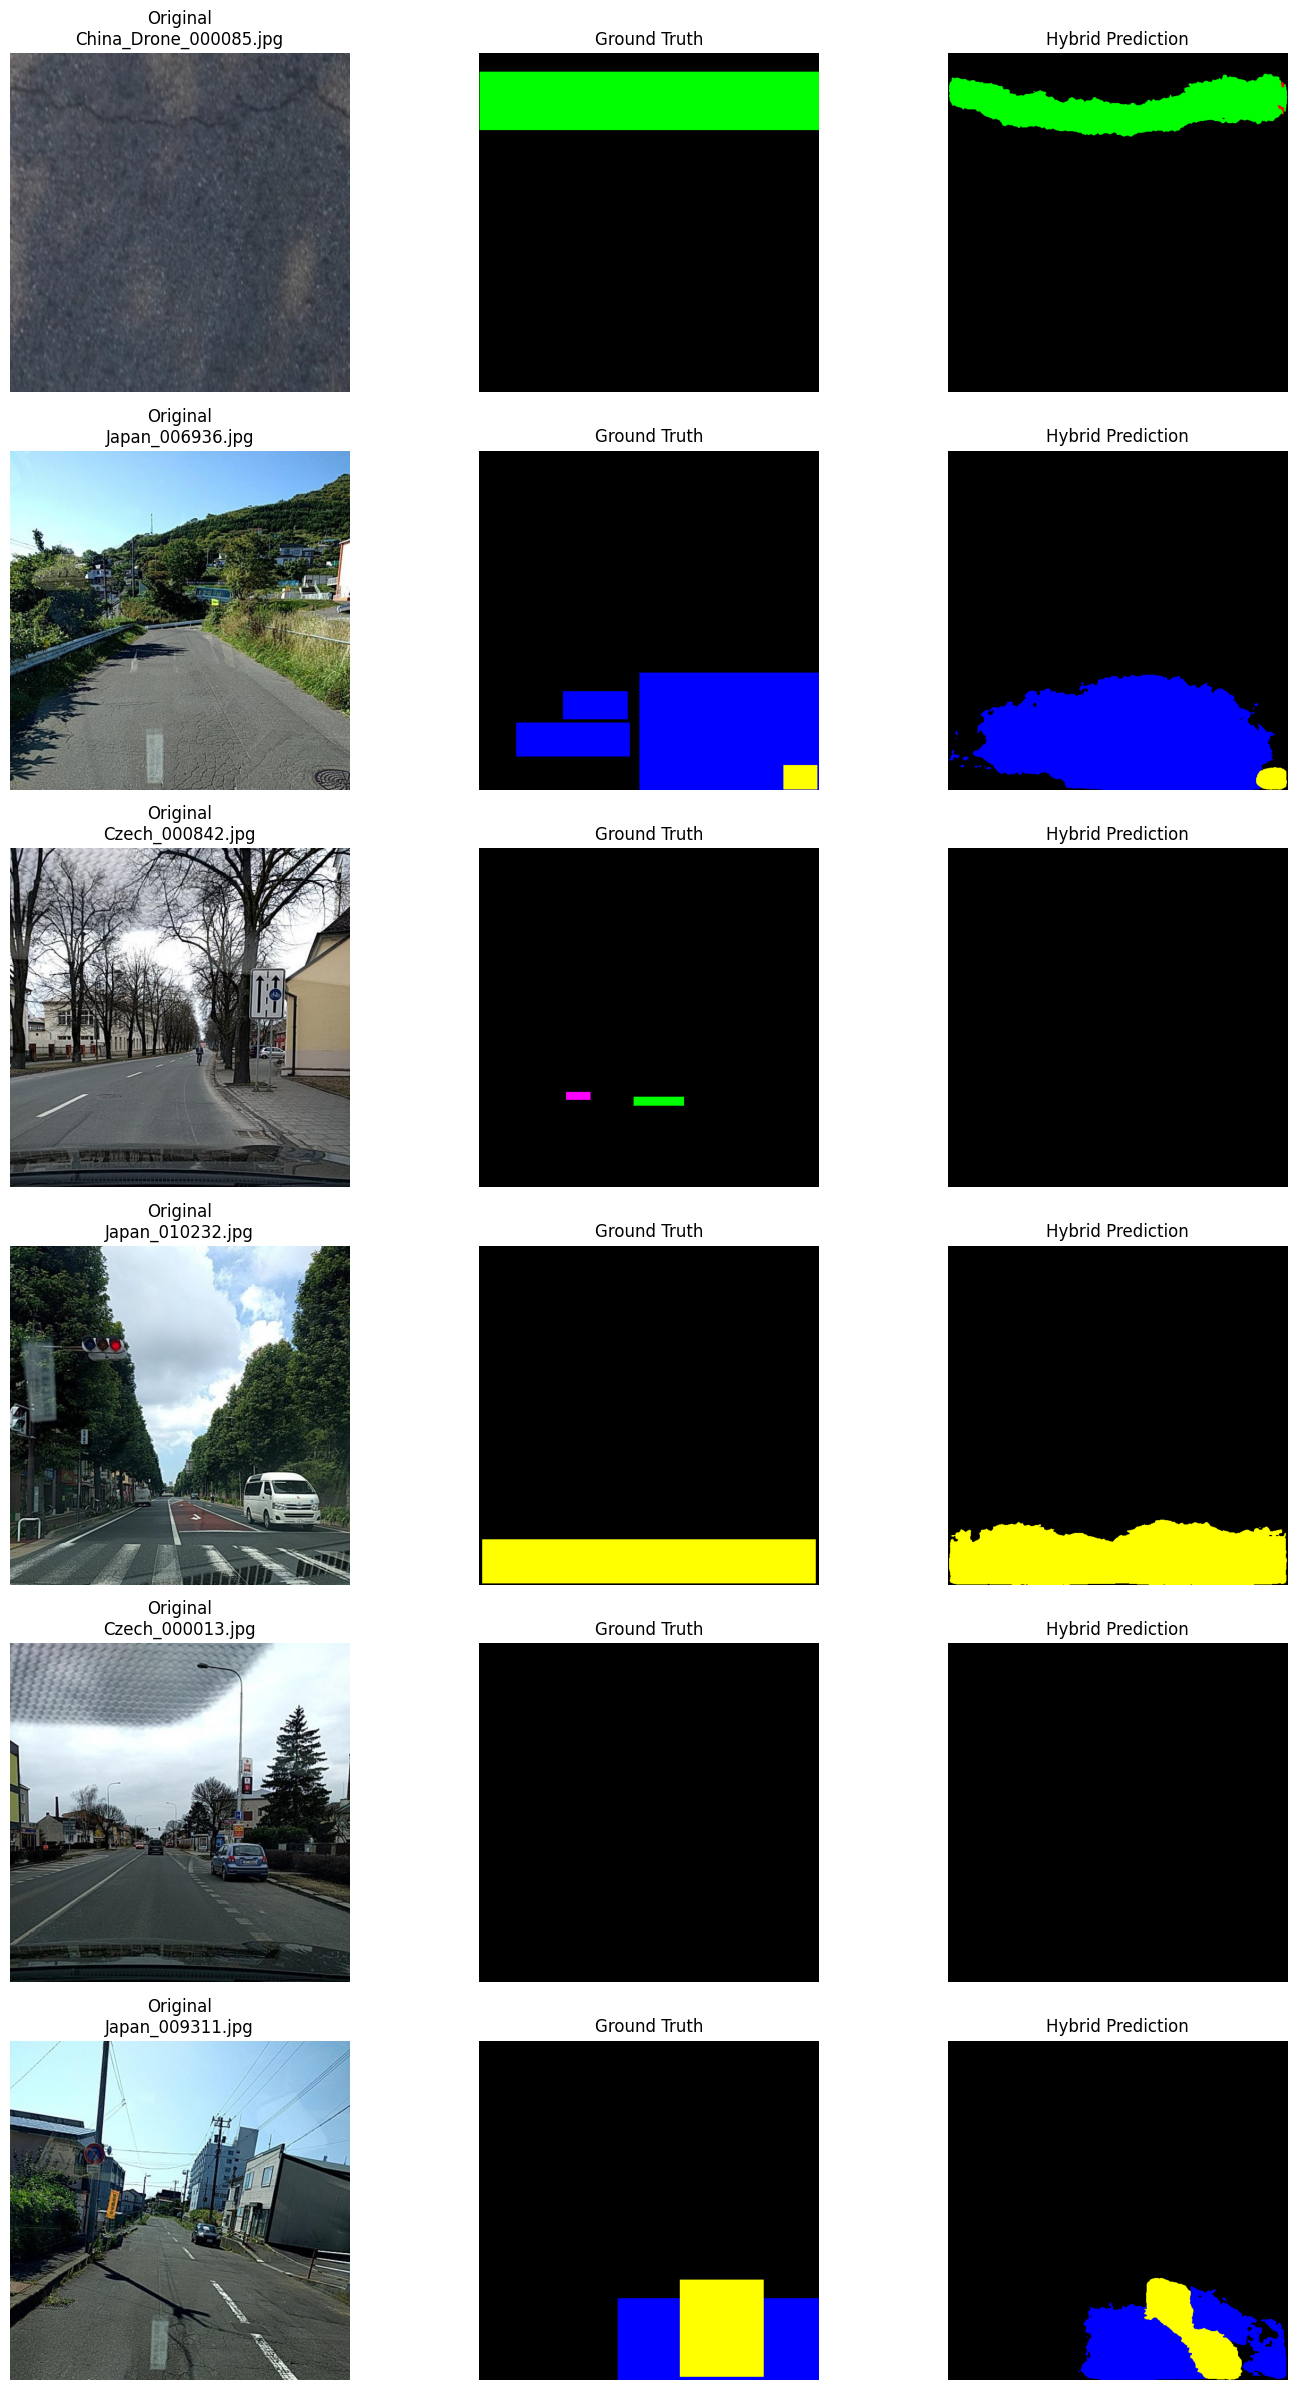

In [16]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Ensure COLORS is defined, or define it if not already in global scope
# In this notebook, COLORS is defined in cell 'viz_code'
COLORS = np.array([[0,0,0], [255,0,0], [0,255,0], [0,0,255], [255,255,0], [255,0,255]], dtype=np.uint8)

# Load the best hybrid model
# Assuming best_hybrid_model_path and hybrid_model are available from previous cells
checkpoint_hybrid = torch.load(best_hybrid_model_path, weights_only=False)
hybrid_model.load_state_dict(checkpoint_hybrid['model'])
hybrid_model.eval()

# Prepare test dataset and loader (reusing definitions from earlier if needed)
# Ensure val_transform is accessible

test_dataset_hybrid_viz = RoadDamageDataset(
    os.path.join(DATASET_ROOT, 'test', 'images'),
    os.path.join(DATASET_ROOT, 'test', 'masks'),
    transform=val_transform
)
# No need for a DataLoader here, as we are sampling individual images

test_imgs = [test_dataset_hybrid_viz.images[i] for i in range(len(test_dataset_hybrid_viz))]
samples = random.sample(test_imgs, min(6, len(test_imgs)))

fig, axes = plt.subplots(len(samples), 3, figsize=(15, 4 * len(samples)))

# Adjust for single row plot if only one sample
if len(samples) == 1:
    axes = np.expand_dims(axes, axis=0)

print(f"Visualizing {len(samples)} hybrid model predictions...")

for idx, img_name in enumerate(samples):
    # Find the original index to load from test_dataset_hybrid_viz
    original_idx = test_dataset_hybrid_viz.images.index(img_name)

    # Get original image and ground truth mask without transformations for display
    img_path = os.path.join(DATASET_ROOT, 'test', 'images', img_name)
    image_orig = cv2.imread(img_path)
    image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)

    mask_path = os.path.join(DATASET_ROOT, 'test', 'masks', os.path.splitext(img_name)[0] + '.png')
    gt_mask_orig = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Prepare image for model inference using val_transform
    augmented_for_inference = val_transform(image=image_orig)
    inp = augmented_for_inference['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.argmax(hybrid_model(inp), dim=1).cpu().numpy()[0]

    # Resize original image and ground truth mask to IMG_SIZE for consistent display
    img_display = cv2.resize(image_orig, (IMG_SIZE, IMG_SIZE))
    gt_display = cv2.resize(gt_mask_orig, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    axes[idx,0].imshow(img_display)
    axes[idx,0].set_title(f'Original\n{img_name}')
    axes[idx,0].axis('off')

    axes[idx,1].imshow(COLORS[gt_display])
    axes[idx,1].set_title('Ground Truth')
    axes[idx,1].axis('off')

    axes[idx,2].imshow(COLORS[pred])
    axes[idx,2].set_title('Hybrid Prediction')
    axes[idx,2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'hybrid_predictions.png'), dpi=150)
plt.show()